# Import ploonetide and other libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from ploonetide import TidalSimulation
from ploonetide.utils import colorline
from ploonetide.utils.functions import mean2axis, find_moon_fate
from ploonetide.utils.constants import GYEAR, KYEAR, DAY, MSUN, AU

-------
## Create TidalSimulation object for planet-moon system. The list of the most important parameters is printed out.

In [2]:
simulation = TidalSimulation(
    system='planet-moon',
    star_mass=1.0,  # Solar masses
    star_radius=1.0,  # Solar radii
    star_rotperiod=10.,  # days
    planet_mass=1.,  # Jupiter masses
    planet_radius=1.,  # Jupiter radii
    planet_orbperiod=10.,  # days
    planet_rotperiod=0.6,  # days
    planet_size_evolution=False,
    planet_internal_evolution=False,
    planet_core_dissipation=False,
    moon_semimaxis=8.,  # Roche radii
    moon_eccentricity=0.0,
)

       _                        _   _     _      
 _ __ | | ___   ___  _ __   ___| |_(_) __| | ___ 
| '_ \| |/ _ \ / _ \| '_ \ / _ \ __| |/ _` |/ _ \
| |_) | | (_) | (_) | | | |  __/ |_| | (_| |  __/
| .__/|_|\___/ \___/|_| |_|\___|\__|_|\__,_|\___|
|_|                                              


Star mass: 1.0 solMass
 Star radius: 1.0 solRad
 Star rotation period: 10.0 d
 Planet orbital period: 10.0 d
 Planet mass: 1.0 jupiterMass
 Planet radius: 1.0 jupiterRad
 Planet eccentricity: 0.1
 Moon mass: 1.0 earthMass
 Moon radius: 1.0 earthRad
 Moon eccentricity: 0.0
 Moon orbital period: 8.0 a_roche (1.9 d)



----
## After building the TidalSimulation class instance, and before running the simulation, you still can modify any parameter in `dir(simulation)`:

In [3]:
# print(dir(simulation))  # Uncomment this line to print all the simulation attributes
simulation.star_mass = 1.0  # Solar masses
simulation.planet_mass = 1.0  # Jupiter masses

In [4]:
# Now let's print the list of all the parameters
# to be used (everything is in SI units)
simulation.parameters

{'Ms': 1.988409870698051e+30,
 'Rs': 695700000.0,
 'Ls': 6.463570700718025e+25,
 'coeff_star': 0.5,
 'star_alpha': 0.25,
 'star_beta': 0.25,
 'os_saturation': 4.3421e-05,
 'star_age': 1.57788e+17,
 'coeff_planet': 0.26401,
 'Mp': 1.8981245973360505e+27,
 'Rp': 71492000.0,
 'planet_alpha': 0.126,
 'planet_beta': 0.02,
 'rigidity': 44600000000.0,
 'E_act': 300000.0,
 'B': 25.0,
 'Ts': 1600.0,
 'Tb': 1800.0,
 'Tl': 2000.0,
 'Cp': 1260.0,
 'ktherm': 2.0,
 'Rac': 1100.0,
 'a2': 1.0,
 'alpha_exp': 0.0001,
 'densm': 5495.021865555213,
 'Mm': 5.972167867791379e+24,
 'Rm': 6378100.0,
 'melt_fr': 0.5,
 'sun_mass_loss_rate': 882124692.301465,
 'sun_omega': 2.67e-06,
 'os_ini': 7.272205216643039e-06,
 'np_ini': 7.272205216643054e-06,
 'op_ini': 0.00012120342027738399,
 'ep_ini': 0.1,
 'mp_ini': 1.8981245973360505e+27,
 'nm_ini': 3.879395428203761e-05,
 'Tm_ini': 541.3854894136051,
 'Em_ini': 0.0,
 'em_ini': 0.0,
 'args': {'star_internal_evolution': False,
  'star_k2q': 1.984408581606224e-07,
  'pl

-----
### Choose the total integration time and time-step

In [5]:
integration_time = 1 * simulation.star_lifespan.value
time_step = 100 * KYEAR

### Choose the integrator and run the simulation

In [6]:
simulation.set_integration_method('rk4')
simulation.run(integration_time, time_step)

Progress: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 steps | 00:50<00:00


----
### Get the times and solutions

In [7]:
times, solutions = simulation.history
planet_rotation_omega = solutions[:, 0]  # Planet rotation rate
planet_mean_motion = solutions[:, 1]  # Planet mean motion
moon_mean_motion = solutions[:, 2]  # Planet mean motion
moon_temperature = solutions[:, 3]  # Moon temperature
moon_tidal_energy = solutions[:, 4]  # Moon tidal energy
if simulation.moon_eccentricity != 0.0:
    moon_eccentricity = solutions[:, 5]  # Moon eccentricity
    
# Compute semi-major axis using nms
moon_semi_ma = mean2axis(moon_mean_motion, simulation.planet_mass.to('kg').value,
                         simulation.moon_mass.to('kg').value)

/Users/Jaime/Documents/MacquarieUni/PhD/software_packages/ploonetide/src/ploonetide/utils/functions.py:255: RuntimeWarning: overflow encountered in square
  return (GCONST * (M + m) / N**2.0)**(1.0 / 3.0)


### Plot the solutions using matplotlib and a few helper functions from ploonetide 

Moon crosses Roche radius in 0.1446 Gyr


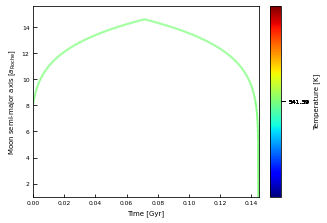

In [8]:
# ************************************************************
# FINDING ROUND-TRIP TIMES OR RUNAWAY TIMES
# ************************************************************
fate = find_moon_fate(
    times, moon_semi_ma,
    simulation.moon_roche_radius.value,
    simulation.planet_hill_radius.value,
)

labels = {'P': r'$\mathrm{Log_{10}}(P_\mathrm{orb})\mathrm{[d]}$',
          'Ms': r'$M_\bigstar[\mathrm{M_\odot}]$', 'Mp': r'$M_\mathrm{p}[\mathrm{M_{jup}}]$',
          't': r'$\mathrm{Log_{10}}(\mathrm{Time})\mathrm{[Gyr]}$'}

labelsize = 7.
markersize = 7.
ticksize = 6.

x = times / GYEAR
y = moon_semi_ma / simulation.moon_roche_radius.value
z = moon_temperature

fig = plt.figure(figsize=(5, 3.5))
ax = fig.add_subplot(1, 1, 1)
lc = colorline(x, y, z, cmap='jet')
cbar = fig.colorbar(lc, orientation='vertical', aspect=17, format="%.2f", pad=0.04)
cbar.set_label(label='Temperature [K]', size=7)
cbar.set_ticks(np.linspace(np.nanmin(z), np.nanmax(z), 9))
cbar.ax.tick_params(labelsize=ticksize)
ax.axhline(simulation.planet_hill_radius.value / simulation.moon_roche_radius.value,
           c="k", ls="--", lw=0.9, zorder=0.0, label="Roche limit")

ax.set_xlim(x.min(), x[fate.index] + (x[4] - x[1]))
ax.set_ylim(1.0, np.nanmax(y[np.isfinite(y)]) + 1)
ax.tick_params(axis='both', direction='in', labelsize=ticksize)

ax.set_xlabel('Time [Gyr]', fontsize=labelsize)
ax.set_ylabel(r'Moon semi-major axis [$a_\mathrm{Roche}$]', fontsize=labelsize)
# ax.legend(loc='upper right', fontsize=labelsize)
fig.savefig('migration.png', dpi=300, facecolor='w')
